<a href="https://colab.research.google.com/github/maxigaarp/teaching/blob/master/TwitterFireWilds_awareness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
%%capture

!pip install geopandas
!pip install utm
!pip install dtw
!pip install optuna

In [11]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dtw import dtw

import utm
import statsmodels.api as sm
import scipy.stats as st

path="/content/drive/My Drive/DataColab/"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
from math import radians, cos, sin, asin, sqrt


def haversine(latlon1, latlon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lat1 = latlon1[0]
    lon1 = latlon1[1]
    lat2 = latlon2[0]
    lon2 = latlon2[1]
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    # Radius of earth in kilometers is 6371
    km = 6371*c
    return km


def ff(latlon1, latlon2, m, sigma):
    return (1-m)*np.exp(-1*(haversine(latlon1, latlon2)/sigma)**2)+m


def normalize(timeseries):
    timeseries=np.array(timeseries)
    if timeseries.max()-timeseries.min()==0:
      return timeseries-timeseries.min()
    else:
      return (timeseries-timeseries.min())/(timeseries.max()-timeseries.min())

In [ ]:
days=["{0:02}".format(i)+"_Jan" for i in range(1,32)]+["{0:02}".format(i)+"_Feb" for i in range(1,29)]


selected_days=days[12:33]

#get fire sources data

fire_data = gpd.read_file(path+"Fire/clip_grilla_100m_ai.shp")
fire_data["latlon"]= [utm.to_latlon(i.centroid.coords[0][0], i.centroid.coords[0][1], 19, "G") for i in fire_data.geometry]


#get cities data

db_cities=pd.read_excel(path+"cities.xlsx")
db_cities.set_index(["Ciudad"],inplace=True)


#get twitter data

stop_words = ["fuego", "incendiar", "quemar", "llamarada", "flama", "sum", "NumTweets"]
twitter_data = {s: pd.read_excel(path+"TweetsResume.xlsx", sheet_name=s) for s in stop_words}
twitter_data["index"] = (twitter_data["sum"]/twitter_data["NumTweets"]).fillna(0)

In [ ]:
fire_data.sum()[days][9:34]

10_Jan      2
11_Jan      8
12_Jan      4
13_Jan      6
14_Jan     13
15_Jan     12
16_Jan     16
17_Jan     19
18_Jan     41
19_Jan     36
20_Jan     80
21_Jan    110
22_Jan     84
23_Jan     65
24_Jan     60
25_Jan    100
26_Jan    173
27_Jan    170
28_Jan     77
29_Jan     58
30_Jan     45
31_Jan     39
01_Feb     28
02_Feb      3
03_Feb      2
dtype: object

In [ ]:
def FireAwarenessIndex(latlon,m,sigma, days=days):
    output = [0 for i in days]
    for i, day in enumerate(days):
        for fire in fire_data[[day, "latlon"]].itertuples():
          if fire[1]==1:
            output[i]+=ff(fire.latlon, latlon, m=m, sigma=sigma)
    return output


In [ ]:
selected_cities=twitter_data["sum"].transpose()[(twitter_data["sum"][9:34].sum()>=50)].index
selected_cities=list(selected_cities.drop("NO_LOC"))

Regiones=["Valparaíso", "Región metropolitana", "Biobio",'Maule','O´Higgins', "Ñuble"]

selected_cities_data=db_cities.loc[selected_cities]
selected_cities_data["TotalTweets"]=twitter_data["NumTweets"].iloc[9:34].sum()
selected_cities_data["TotalFireTweets"]=twitter_data["sum"].iloc[9:34].sum()
selected_cities_data=selected_cities_data[selected_cities_data.Region.isin(Regiones)]
selected_cities_data["TwitterUsage"]= selected_cities_data["TotalTweets"]/selected_cities_data["TotalTweets"].sum()


In [ ]:
# =============================================================================
#
# plt.scatter(np.array(centroids).transpose()[0], np.array(centroids).transpose()[1], s=0.1)
# plt.scatter(np.array(affected).transpose()[0], np.array(affected).transpose()[1], s=0.3)
#
# =============================================================================

l1_norm = lambda x, y: np.abs(x - y)
l2_norm = lambda x, y: (x - y)**2

data= {"m":[], "sigma":[], "city":[], "pearson":[], "spearman":[], "kendalltau":[], "MSE":[],
       "MAE":[], "dtw_L1_w5_s01":[], "dtw_L2_w5_s01":[],"dtw_L1_w5_s02":[], "dtw_L2_w5_s02":[]}

def add(d):
  for k,v in d.items():
    data[k].append(v)

ms=np.linspace(0,0.3,51)
sigmas=np.linspace(4,50,51)

for m in ms:
  for sigma in sigmas:
    print(m,sigma)
    for city in selected_cities_data[["lat","lon"]].itertuples():
      fai=normalize(FireAwarenessIndex((city.lat,city.lon),m,sigma,days=days[9:34]))
      twi=normalize(twitter_data["index"][city[0]][9:34])
      add({
            "m":m,
            "sigma":sigma,
            "city":city[0],
            "pearson":st.pearsonr(fai,twi)[0], 
            "spearman":st.spearmanr(fai,twi)[0],
            "kendalltau":st.kendalltau(fai,twi)[0], 
            "MSE":l2_norm(fai,twi).sum()/25.,
            "MAE":l1_norm(fai,twi).sum()/25.,
            "dtw_L1_w5_s01":dtw(fai,twi, l1_norm, warp=1, w=3, s=1.01)[0], 
            "dtw_L2_w5_s01":dtw(fai,twi, l2_norm, warp=1, w=3, s=1.01)[0],
            "dtw_L1_w5_s02":dtw(fai,twi, l1_norm, warp=1, w=3, s=1.02)[0], 
            "dtw_L2_w5_s02":dtw(fai,twi, l2_norm, warp=1, w=3, s=1.02)[0]
      })
  pd.DataFrame(data).to_excel(path+"Awareness_f.xlsx")

0.0 4.0
0.0 4.92
0.0 5.84
0.0 6.76
0.0 7.68
0.0 8.600000000000001
0.0 9.52
0.0 10.440000000000001
0.0 11.36
0.0 12.280000000000001
0.0 13.200000000000001
0.0 14.120000000000001
0.0 15.040000000000001
0.0 15.96
0.0 16.880000000000003
0.0 17.8
0.0 18.72
0.0 19.64
0.0 20.560000000000002
0.0 21.48
0.0 22.400000000000002
0.0 23.32
0.0 24.240000000000002
0.0 25.16
0.0 26.080000000000002
0.0 27.0
0.0 27.92
0.0 28.84
0.0 29.76
0.0 30.68
0.0 31.6
0.0 32.519999999999996
0.0 33.44
0.0 34.36
0.0 35.28
0.0 36.2
0.0 37.120000000000005
0.0 38.04
0.0 38.96
0.0 39.88
0.0 40.800000000000004
0.0 41.72
0.0 42.64
0.0 43.56
0.0 44.480000000000004
0.0 45.4
0.0 46.32
0.0 47.24
0.0 48.160000000000004
0.0 49.080000000000005
0.0 50.0
0.006 4.0
0.006 4.92
0.006 5.84
0.006 6.76
0.006 7.68
0.006 8.600000000000001
0.006 9.52
0.006 10.440000000000001
0.006 11.36
0.006 12.280000000000001
0.006 13.200000000000001
0.006 14.120000000000001
0.006 15.040000000000001
0.006 15.96
0.006 16.880000000000003
0.006 17.8
0.006 18.

In [12]:
data=pd.DataFrame(data)

#data=pd.read_parquet("Awareness_final.parquet")

data=data.merge(selected_cities_data.TwitterUsage, left_on=["city"], right_index=True)

#there are 88 nan values in correlation coeffs, I set them in 0, ie no correlation.
data.fillna(0,inplace=True)


In [13]:
data

,m,sigma,city,pearson,spearman,kendalltau,MSE,MAE,dtw_L1_w5_s01,dtw_L2_w5_s01,dtw_L1_w5_s02,dtw_L2_w5_s02,TwitterUsage
0,0.0,4.00,Algarrobo,0.662512,0.639247,0.500046,0.065214,0.181420,3.694068,0.982041,3.928006,1.044969,0.001135
61,0.0,4.92,Algarrobo,0.647059,0.639247,0.500046,0.062379,0.179022,3.237293,0.739441,3.447387,0.789516,0.001135
122,0.0,5.84,Algarrobo,0.631680,0.639124,0.499209,0.062372,0.180510,3.105679,0.688982,3.305368,0.736662,0.001135
183,0.0,6.76,Algarrobo,0.620729,0.639124,0.499209,0.063061,0.181392,3.123315,0.702635,3.324777,0.751368,0.001135
244,0.0,7.68,Algarrobo,0.613027,0.639124,0.499209,0.063779,0.181988,3.138899,0.732126,3.342091,0.782751,0.001135
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158416,0.3,46.32,Viña del Mar,0.732225,0.736923,0.606667,0.038939,0.126890,2.412889,0.576155,2.587368,0.625868,0.051475
158477,0.3,47.24,Viña del Mar,0.732244,0.736923,0.606667,0.038939,0.126937,2.417865,0.576988,2.592532,0.626700,0.051475
158538,0.3,48.16,Viña del Mar,0.732259,0.736923,0.606667,0.038940,0.126983,2.422871,0.577842,2.597712,0.627555,0.051475
158599,0.3,49.08,Viña del Mar,0.732270,0.736923,0.606667,0.038940,0.127027,2.427910,0.578717,2.602911,0.628422,0.051475


In [14]:
all_stats=["pearson", "spearman", "kendalltau", "MSE", "MAE", "dtw_L1_w5_s01", "dtw_L2_w5_s01","dtw_L1_w5_s02", "dtw_L2_w5_s02"]

stats_parameters=data.groupby(["m","sigma"]).apply(lambda x:(x[all_stats].multiply(x["TwitterUsage"],axis=0)).sum()).reset_index()

In [18]:
#ms=np.linspace(0,1,51)
#sigmas=np.linspace(4,300,51)

def plot_colormap(stat):
  X,Y=np.meshgrid(sigmas,ms)
  Z=stats_parameters[stat].to_numpy().reshape((51,51))
  plt.pcolor(X, Y, Z, cmap='RdBu')
  plt.colorbar()
  plt.ylabel('$m$',fontsize=14)
  plt.xlabel(r'$\sigma$',fontsize=14)
  plt.savefig(stat+".pdf")
  plt.show()

In [16]:
data.to_parquet("Awareness_NEW3.parquet")

pearson:
Maximum at:
m         0.018
sigma    10.440
Name: 160, dtype: float64


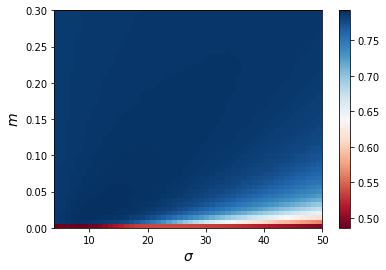

spearman:
Maximum at:
m         0.084
sigma    23.320
Name: 735, dtype: float64


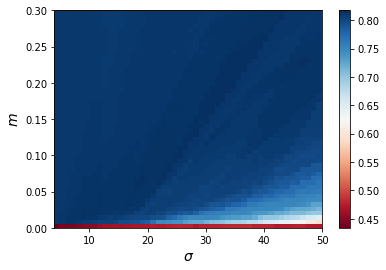

kendalltau:
Maximum at:
m         0.24
sigma    50.00
Name: 2090, dtype: float64


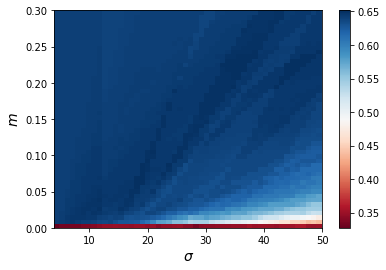

MSE:
Minimum at:
m         0.042
sigma    11.360
Name: 365, dtype: float64


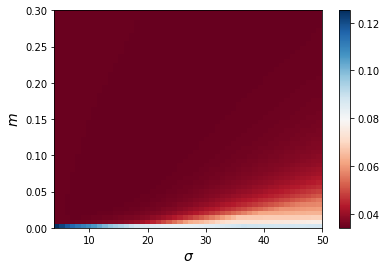

MAE:
Minimum at:
m         0.078
sigma    16.880
Name: 677, dtype: float64


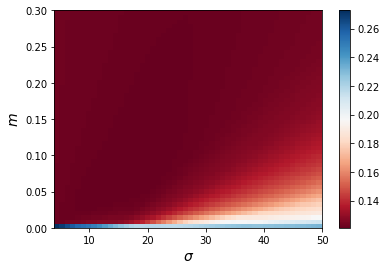

dtw_L1_w5_s01:
Minimum at:
m         0.072
sigma    20.560
Name: 630, dtype: float64


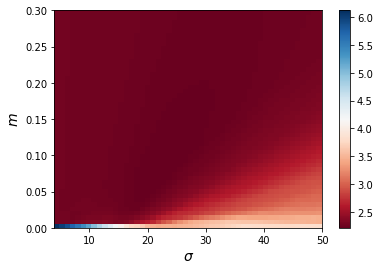

dtw_L2_w5_s01:
Minimum at:
m         0.192
sigma    28.840
Name: 1659, dtype: float64


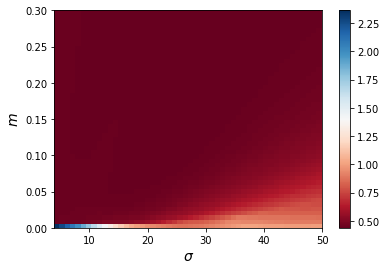

dtw_L1_w5_s02:
Minimum at:
m         0.072
sigma    20.560
Name: 630, dtype: float64


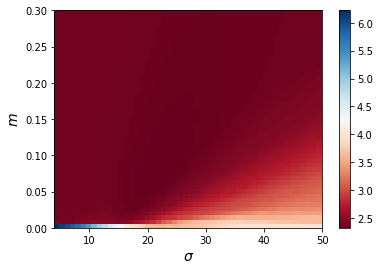

dtw_L2_w5_s02:
Minimum at:
m         0.18
sigma    27.92
Name: 1556, dtype: float64


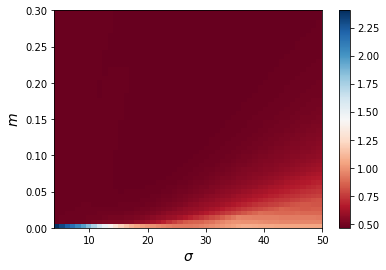

In [20]:
for stat in all_stats:
  print(stat+":")
  if stat in ["pearson", "spearman", "kendalltau"]:
    print("Maximum at:")
    print(stats_parameters.loc[stats_parameters[stat].argmax()][["m","sigma"]])
  else:
    print("Minimum at:")
    print(stats_parameters.loc[stats_parameters[stat].argmin()][["m","sigma"]])
  plot_colormap(stat)

In [ ]:
import optuna

stat="dtw"

def objective(trial):
  m=trial.suggest_float("m",0.12,0.14)
  sigma=trial.suggest_float("sigma",23,27)
  score=0
  for city in selected_cities_data[["lat","lon"]].itertuples():
    fai=normalize(FireAwarenessIndex((city.lat,city.lon),m,sigma,days=days[12:33]))
    twi=normalize(twitter_data["index"][city[0]][12:33])
    if stat=="pearson":
      score+=st.pearsonr(fai,twi)[0]*selected_cities_data["TwitterUsage"][city[0]]
    elif stat=="spearman":
      score+=st.spearmanr(fai,twi)[0]*selected_cities_data["TwitterUsage"][city[0]]
    elif stat=="kendalltau":
      score+=st.kendalltau(fai,twi)[0]*selected_cities_data["TwitterUsage"][city[0]]
    elif stat=="MSE":
      score+=l2_norm(fai,twi).sum()/21.*selected_cities_data["TwitterUsage"][city[0]]
    elif stat=="MAE":
      score+=l1_norm(fai,twi).sum()/21.*selected_cities_data["TwitterUsage"][city[0]]
    elif stat=="dtw":
      score+=dtw(fai,twi, l1_norm, warp=1, w=3, s=1.01)[0]*selected_cities_data["TwitterUsage"][city[0]]
  return score

study = optuna.create_study(direction="minimize")
study.enqueue_trial({'m': 0.13024402432579119, 'sigma': 24.613169111892393})
study.optimize(objective, n_trials=50)

[I 2020-11-09 18:43:29,970] A new study created in memory with name: no-name-aa09d43f-b1c6-4371-862e-576ded58028b
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: ExperimentalWarning:

enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.

/usr/local/lib/python3.6/dist-packages/optuna/study.py:505: ExperimentalWarning:

create_trial is experimental (supported from v2.0.0). The interface can change in the future.

/usr/local/lib/python3.6/dist-packages/optuna/study.py:505: ExperimentalWarning:

add_trial is experimental (supported from v2.0.0). The interface can change in the future.

[I 2020-11-09 18:43:35,485] Trial 0 finished with value: 2.0310667050437226 and parameters: {'m': 0.13024402432579119, 'sigma': 24.613169111892393}. Best is trial 0 with value: 2.0310667050437226.
[I 2020-11-09 18:43:40,949] Trial 1 finished with value: 2.0314687955267274 and parameters: {'m': 0.12207273555878206, 'sigma': 24.57129628266299}. Best is

{'city': 'Algarrobo', 'pearson': 0.488530390500556, 'spearman': 0.4889007606424965, 'kendalltau': 0.3395982212978464, 'MSE': 0.0843736168882284, 'MAE': 0.25069611777125267, 'dtw_L1_w5_s01': 3.5608726282225405, 'dtw_L2_w5_s01': 0.8410214515176575, 'dtw_L1_w5_s02': 3.717177816483985, 'dtw_L2_w5_s02': 0.8735446479059112}


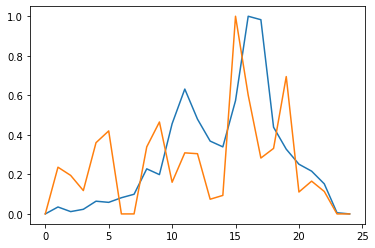

{'city': 'Buin', 'pearson': 0.5371774639079624, 'spearman': 0.7252828673468142, 'kendalltau': 0.5027293925217254, 'MSE': 0.09380461288298504, 'MAE': 0.2390239609417163, 'dtw_L1_w5_s01': 3.895876131517792, 'dtw_L2_w5_s01': 1.0104308443710037, 'dtw_L1_w5_s02': 4.102390058671816, 'dtw_L2_w5_s02': 1.064704943123154}


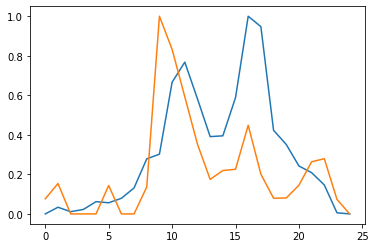

{'city': 'Bulnes', 'pearson': 0.5455671163994319, 'spearman': 0.7277621294912151, 'kendalltau': 0.5472151719794001, 'MSE': 0.08400704066713166, 'MAE': 0.1958749140919598, 'dtw_L1_w5_s01': 3.45689444305535, 'dtw_L2_w5_s01': 0.891378973188113, 'dtw_L1_w5_s02': 3.578548484679263, 'dtw_L2_w5_s02': 0.9119244940113079}


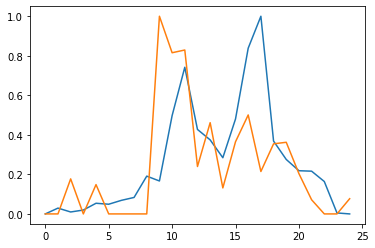

{'city': 'Cañete', 'pearson': 0.43376423393911223, 'spearman': 0.5472253804853632, 'kendalltau': 0.39866912501296065, 'MSE': 0.10614572141431947, 'MAE': 0.26114977902111175, 'dtw_L1_w5_s01': 3.941260664111264, 'dtw_L2_w5_s01': 0.9292595519445385, 'dtw_L1_w5_s02': 4.123370498508475, 'dtw_L2_w5_s02': 0.9775114384102455}


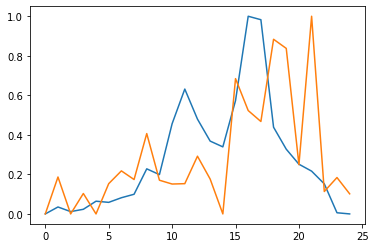

{'city': 'Cauquenes', 'pearson': 0.6210950300698129, 'spearman': 0.7263906477283525, 'kendalltau': 0.5618052895441062, 'MSE': 0.08347134409235073, 'MAE': 0.19814265753670554, 'dtw_L1_w5_s01': 3.365019649141507, 'dtw_L2_w5_s01': 0.9898985350172806, 'dtw_L1_w5_s02': 3.4859635796944906, 'dtw_L2_w5_s02': 1.052423365697609}


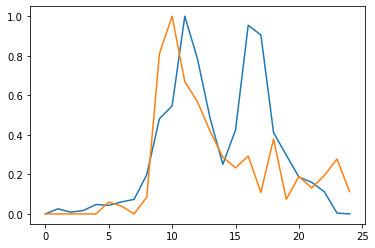

{'city': 'Chiguayante', 'pearson': 0.7922533017170029, 'spearman': 0.7059278458196807, 'kendalltau': 0.5393702941891104, 'MSE': 0.03263239796475249, 'MAE': 0.1497855070300441, 'dtw_L1_w5_s01': 2.3163535565554074, 'dtw_L2_w5_s01': 0.2616997110579591, 'dtw_L1_w5_s02': 2.4217528887807287, 'dtw_L2_w5_s02': 0.27520965055446855}


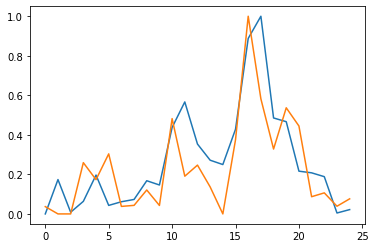

{'city': 'Chillan', 'pearson': 0.6359505144069679, 'spearman': 0.7676923076923077, 'kendalltau': 0.5866666666666666, 'MSE': 0.1371298496434204, 'MAE': 0.3402446786791486, 'dtw_L1_w5_s01': 5.190328864158786, 'dtw_L2_w5_s01': 1.3702820241428557, 'dtw_L1_w5_s02': 5.47521257697886, 'dtw_L2_w5_s02': 1.4817647236363165}


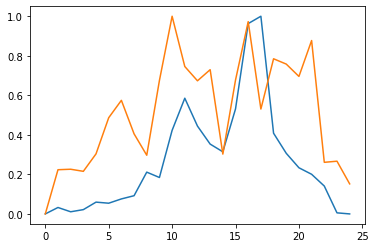

{'city': 'Chimbarongo', 'pearson': 0.568496388130218, 'spearman': 0.6360150026478935, 'kendalltau': 0.4599366700340344, 'MSE': 0.08987841276897342, 'MAE': 0.23040064524065465, 'dtw_L1_w5_s01': 3.487297507458699, 'dtw_L2_w5_s01': 0.9096883654882446, 'dtw_L1_w5_s02': 3.6334673694834922, 'dtw_L2_w5_s02': 0.9630310235936194}


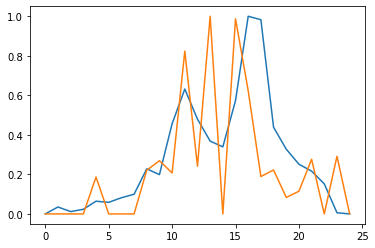

{'city': 'Colina', 'pearson': 0.5315447732236663, 'spearman': 0.5830679707814499, 'kendalltau': 0.40675972312760167, 'MSE': 0.09359228772141656, 'MAE': 0.2390967660177868, 'dtw_L1_w5_s01': 3.8384393510006993, 'dtw_L2_w5_s01': 0.9194916912346626, 'dtw_L1_w5_s02': 3.954389334103655, 'dtw_L2_w5_s02': 0.94737367611691}


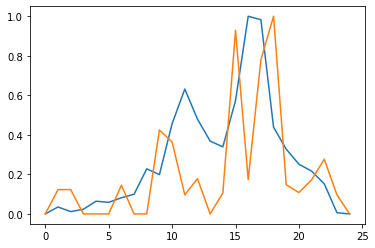

{'city': 'Concepción', 'pearson': 0.843812633999292, 'spearman': 0.86, 'kendalltau': 0.6999999999999998, 'MSE': 0.02714371285632213, 'MAE': 0.12428626217292751, 'dtw_L1_w5_s01': 2.2450293710721247, 'dtw_L2_w5_s01': 0.34087639000113207, 'dtw_L1_w5_s02': 2.3086592563444057, 'dtw_L2_w5_s02': 0.35522443609379667}


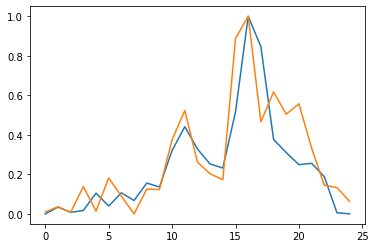

{'city': 'Concon', 'pearson': 0.5186349862610253, 'spearman': 0.40465654010616586, 'kendalltau': 0.28475751840963354, 'MSE': 0.09036040062623739, 'MAE': 0.25455937994854155, 'dtw_L1_w5_s01': 4.623158363912868, 'dtw_L2_w5_s01': 1.1918348046182474, 'dtw_L1_w5_s02': 4.728268140495562, 'dtw_L2_w5_s02': 1.2468242405341523}


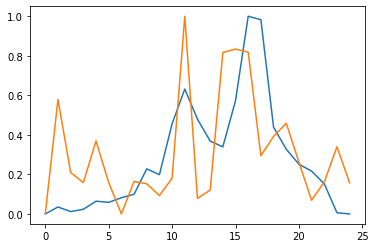

{'city': 'Constitucion', 'pearson': 0.6760387793787603, 'spearman': 0.6655756388925533, 'kendalltau': 0.5540825127298775, 'MSE': 0.07141644324331342, 'MAE': 0.18614029068801607, 'dtw_L1_w5_s01': 2.530783845905647, 'dtw_L2_w5_s01': 0.5371872437744519, 'dtw_L1_w5_s02': 2.609421098490838, 'dtw_L2_w5_s02': 0.5615424782491234}


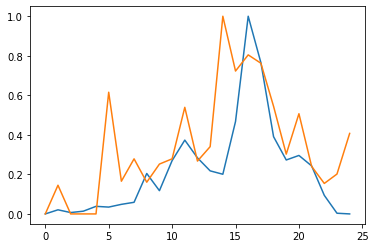

{'city': 'Coronel', 'pearson': 0.4589838838320409, 'spearman': 0.5458742166758995, 'kendalltau': 0.43739626895768646, 'MSE': 0.12687622970559168, 'MAE': 0.29958007787257146, 'dtw_L1_w5_s01': 4.735942008066859, 'dtw_L2_w5_s01': 1.1340519258439048, 'dtw_L1_w5_s02': 5.0679830551601155, 'dtw_L2_w5_s02': 1.218351191684284}


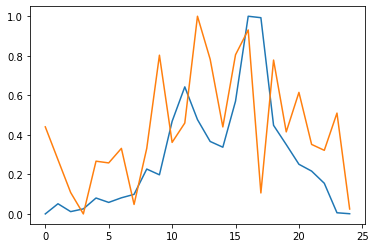

{'city': 'Curacavi', 'pearson': 0.7200246953345167, 'spearman': 0.785871285866888, 'kendalltau': 0.5942968872712312, 'MSE': 0.06777046465080912, 'MAE': 0.19699555555151324, 'dtw_L1_w5_s01': 3.204929075849865, 'dtw_L2_w5_s01': 0.5851578098597767, 'dtw_L1_w5_s02': 3.398447863724432, 'dtw_L2_w5_s02': 0.6150730047071882}


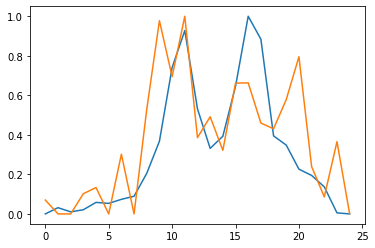

{'city': 'Curanilahue', 'pearson': 0.407943520869634, 'spearman': 0.3258984728589756, 'kendalltau': 0.24235966538557746, 'MSE': 0.11288187097293235, 'MAE': 0.2778069232217135, 'dtw_L1_w5_s01': 5.495723433462911, 'dtw_L2_w5_s01': 1.676128301524108, 'dtw_L1_w5_s02': 5.590476674994031, 'dtw_L2_w5_s02': 1.7967004263610862}


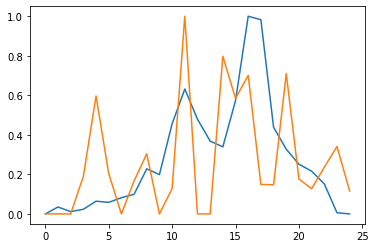

{'city': 'Curico', 'pearson': 0.7357657701184758, 'spearman': 0.8278515252195459, 'kendalltau': 0.6377304379459398, 'MSE': 0.10865648354038646, 'MAE': 0.2530245165954077, 'dtw_L1_w5_s01': 4.173662674797473, 'dtw_L2_w5_s01': 1.2390022087525345, 'dtw_L1_w5_s02': 4.3701045961730145, 'dtw_L2_w5_s02': 1.3073666743096068}


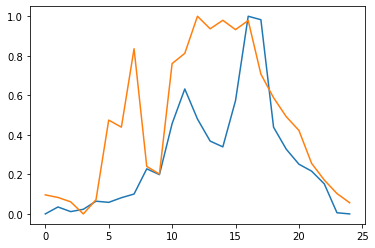

{'city': 'Florida', 'pearson': 0.816186092192274, 'spearman': 0.8090017460672422, 'kendalltau': 0.631052632312998, 'MSE': 0.03663711342976992, 'MAE': 0.15884921659800305, 'dtw_L1_w5_s01': 1.9990885658806572, 'dtw_L2_w5_s01': 0.21854296435299322, 'dtw_L1_w5_s02': 2.090683417789162, 'dtw_L2_w5_s02': 0.23007197641222193}


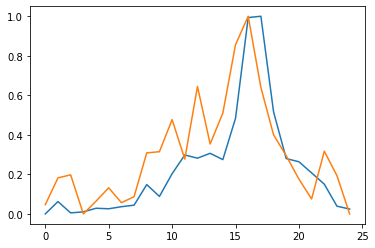

{'city': 'Graneros', 'pearson': 0.17313890915245223, 'spearman': 0.3342905673831673, 'kendalltau': 0.23804761428476162, 'MSE': 0.17187101616925288, 'MAE': 0.32532612453281695, 'dtw_L1_w5_s01': 5.243712454443281, 'dtw_L2_w5_s01': 1.781108149079021, 'dtw_L1_w5_s02': 5.551188115145157, 'dtw_L2_w5_s02': 1.8790082458773953}


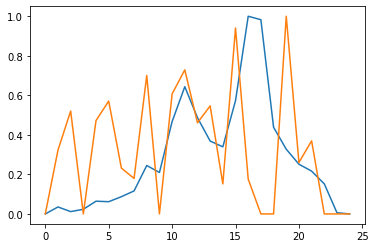

{'city': 'Hualqui', 'pearson': 0.7409905310968071, 'spearman': 0.6793781140489731, 'kendalltau': 0.5348405573334051, 'MSE': 0.0477127080686314, 'MAE': 0.18845118495897614, 'dtw_L1_w5_s01': 3.3282124623516465, 'dtw_L2_w5_s01': 0.7083905227542344, 'dtw_L1_w5_s02': 3.3613923276047117, 'dtw_L2_w5_s02': 0.7255382524377334}


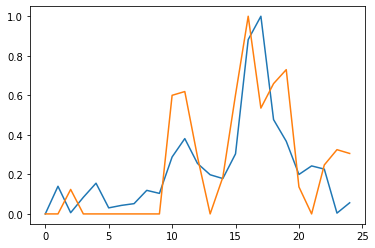

{'city': 'Isla de Maipo', 'pearson': 0.6234119483010971, 'spearman': 0.6243265899234036, 'kendalltau': 0.4522670168666454, 'MSE': 0.09625617922126459, 'MAE': 0.2603767642530155, 'dtw_L1_w5_s01': 3.6752636425714424, 'dtw_L2_w5_s01': 0.7843678148851512, 'dtw_L1_w5_s02': 3.8894656044302742, 'dtw_L2_w5_s02': 0.8330458247133425}


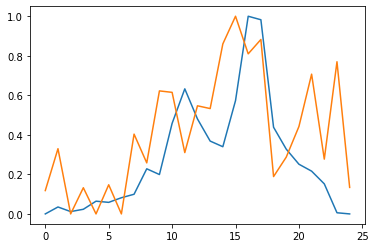

{'city': 'Lebu', 'pearson': 0.3248673196673578, 'spearman': 0.5208855536477822, 'kendalltau': 0.3557067007550456, 'MSE': 0.12445648379038317, 'MAE': 0.26941646816834286, 'dtw_L1_w5_s01': 4.597574027319071, 'dtw_L2_w5_s01': 1.1365378208671504, 'dtw_L1_w5_s02': 4.714822195099962, 'dtw_L2_w5_s02': 1.181401468329594}


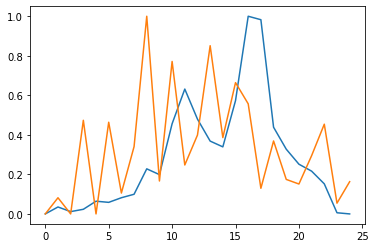

{'city': 'Limache', 'pearson': 0.1814508243121784, 'spearman': 0.2556304564834644, 'kendalltau': 0.15436328523332168, 'MSE': 0.15615885547248642, 'MAE': 0.3010083652909559, 'dtw_L1_w5_s01': 5.052529761891755, 'dtw_L2_w5_s01': 2.097384698660171, 'dtw_L1_w5_s02': 5.330276025931594, 'dtw_L2_w5_s02': 2.2378604878109556}


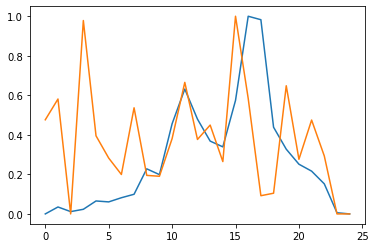

{'city': 'Linares', 'pearson': 0.8637715976177671, 'spearman': 0.80438547362178, 'kendalltau': 0.6110192154141726, 'MSE': 0.023736705599016653, 'MAE': 0.1280188205009655, 'dtw_L1_w5_s01': 2.541887693086925, 'dtw_L2_w5_s01': 0.3500113034322679, 'dtw_L1_w5_s02': 2.6264203914459205, 'dtw_L2_w5_s02': 0.36552999427785976}


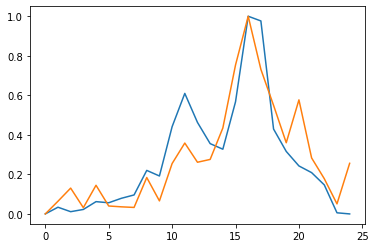

{'city': 'Lo Miranda', 'pearson': 0.3253784058665232, 'spearman': 0.2812620446747473, 'kendalltau': 0.1939810180062888, 'MSE': 0.22203438216880167, 'MAE': 0.41949868735599294, 'dtw_L1_w5_s01': 7.172311816990276, 'dtw_L2_w5_s01': 3.1131130087131718, 'dtw_L1_w5_s02': 7.531632255202494, 'dtw_L2_w5_s02': 3.3756068377983013}


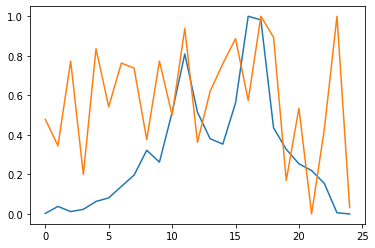

{'city': 'Longavi', 'pearson': 0.41612152000005675, 'spearman': 0.4855954283876194, 'kendalltau': 0.3302232246514455, 'MSE': 0.12734248228241235, 'MAE': 0.2919781810901296, 'dtw_L1_w5_s01': 5.004946001688377, 'dtw_L2_w5_s01': 1.4859464079674483, 'dtw_L1_w5_s02': 5.174919900481887, 'dtw_L2_w5_s02': 1.5735756978597581}


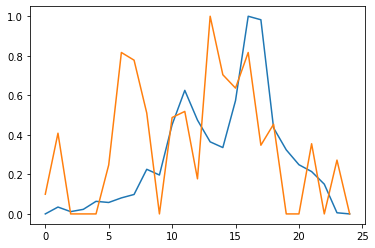

{'city': 'Los Andes', 'pearson': 0.5457874909667897, 'spearman': 0.5798383993843785, 'kendalltau': 0.41471571906354515, 'MSE': 0.072947767570199, 'MAE': 0.19874982292917776, 'dtw_L1_w5_s01': 3.051296625576205, 'dtw_L2_w5_s01': 0.5194044562323888, 'dtw_L1_w5_s02': 3.1651746182584493, 'dtw_L2_w5_s02': 0.5564775619436915}


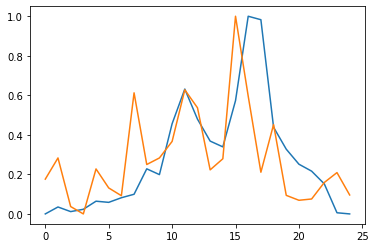

{'city': 'Los Angeles', 'pearson': 0.7918446040699981, 'spearman': 0.8332371764059185, 'kendalltau': 0.6110192154141726, 'MSE': 0.0608481918414897, 'MAE': 0.2090517213195032, 'dtw_L1_w5_s01': 3.4777354258206477, 'dtw_L2_w5_s01': 0.648832826072825, 'dtw_L1_w5_s02': 3.722547256121166, 'dtw_L2_w5_s02': 0.6901456425204449}


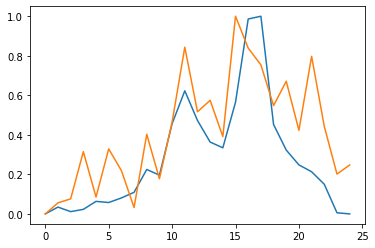

{'city': 'Lota', 'pearson': 0.21297671124551934, 'spearman': 0.42692307692307696, 'kendalltau': 0.3199999999999999, 'MSE': 0.12288708617258644, 'MAE': 0.2649347605976591, 'dtw_L1_w5_s01': 4.5480475955603, 'dtw_L2_w5_s01': 1.5637610734433398, 'dtw_L1_w5_s02': 4.760387723459687, 'dtw_L2_w5_s02': 1.6456237436446388}


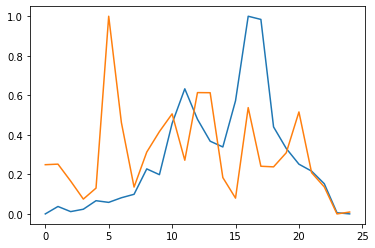

{'city': 'Machali', 'pearson': 0.5084991252658125, 'spearman': 0.5044325355805104, 'kendalltau': 0.3299831645537221, 'MSE': 0.10818656178189967, 'MAE': 0.29085838838853356, 'dtw_L1_w5_s01': 4.990509862469743, 'dtw_L2_w5_s01': 1.3489845060903087, 'dtw_L1_w5_s02': 5.110034642903631, 'dtw_L2_w5_s02': 1.452294789173628}


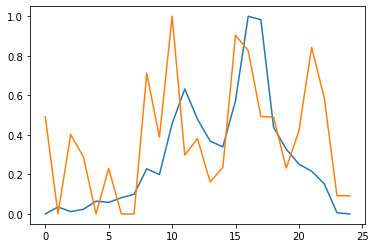

{'city': 'Marchihue', 'pearson': -0.15519244092789064, 'spearman': -0.12738118380897848, 'kendalltau': -0.10385274200821928, 'MSE': 0.23281212524744693, 'MAE': 0.4233974680707486, 'dtw_L1_w5_s01': 6.3539194232507565, 'dtw_L2_w5_s01': 2.525881503059644, 'dtw_L1_w5_s02': 6.661647641140314, 'dtw_L2_w5_s02': 2.783802215620439}


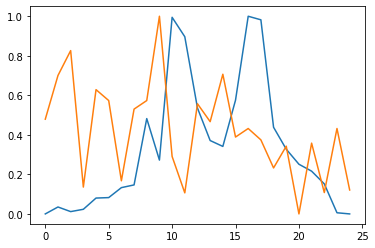

{'city': 'Maule', 'pearson': 0.6641518004281015, 'spearman': 0.6597422703306326, 'kendalltau': 0.4908187140212206, 'MSE': 0.07803883192903374, 'MAE': 0.23574872944472527, 'dtw_L1_w5_s01': 3.3038166197809713, 'dtw_L2_w5_s01': 0.7500826471772594, 'dtw_L1_w5_s02': 3.4820718993643767, 'dtw_L2_w5_s02': 0.7851310791173127}


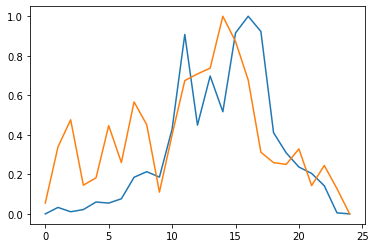

{'city': 'Melipilla', 'pearson': 0.19894483428283505, 'spearman': 0.2530769230769231, 'kendalltau': 0.17333333333333328, 'MSE': 0.2066804042468276, 'MAE': 0.3978469540525317, 'dtw_L1_w5_s01': 6.493678131017686, 'dtw_L2_w5_s01': 2.5753470759115316, 'dtw_L1_w5_s02': 6.669580789297037, 'dtw_L2_w5_s02': 2.651693741922142}


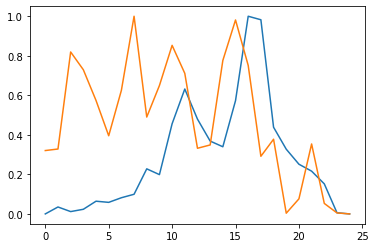

{'city': 'Molina', 'pearson': 0.5258070609366673, 'spearman': 0.5761831473643709, 'kendalltau': 0.4013377926421405, 'MSE': 0.1105731190136588, 'MAE': 0.28168953485594506, 'dtw_L1_w5_s01': 4.622219895853388, 'dtw_L2_w5_s01': 1.2603378333271493, 'dtw_L1_w5_s02': 4.9043196713904225, 'dtw_L2_w5_s02': 1.3518274624787545}


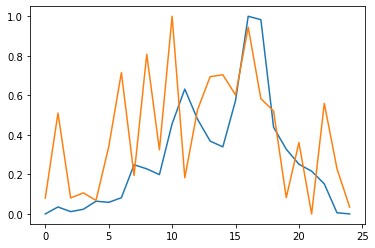

{'city': 'Paine', 'pearson': 0.5468536079447771, 'spearman': 0.688036016447136, 'kendalltau': 0.5085476277156077, 'MSE': 0.08297782321269638, 'MAE': 0.21351386461853064, 'dtw_L1_w5_s01': 2.3321434635041527, 'dtw_L2_w5_s01': 0.4013896383200857, 'dtw_L1_w5_s02': 2.372163678569876, 'dtw_L2_w5_s02': 0.4063940195305942}


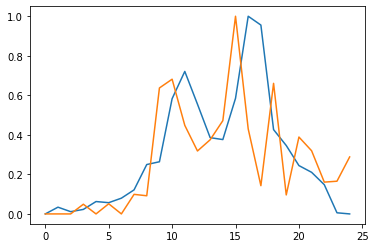

{'city': 'Penco', 'pearson': 0.7678686452573587, 'spearman': 0.7218983148189015, 'kendalltau': 0.543608733469718, 'MSE': 0.038412628701086596, 'MAE': 0.1709743026669254, 'dtw_L1_w5_s01': 3.0345554925783498, 'dtw_L2_w5_s01': 0.5227507340570697, 'dtw_L1_w5_s02': 3.157840273227456, 'dtw_L2_w5_s02': 0.5559943527976059}


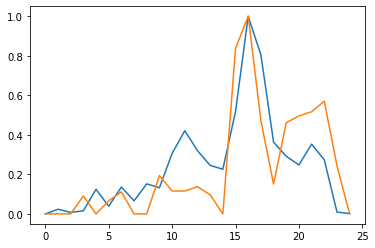

{'city': 'Peñaflor', 'pearson': 0.6605455975274515, 'spearman': 0.538355452339551, 'kendalltau': 0.390557564601693, 'MSE': 0.0744264368291083, 'MAE': 0.22031258025029107, 'dtw_L1_w5_s01': 3.923042208265161, 'dtw_L2_w5_s01': 1.1329427934768965, 'dtw_L1_w5_s02': 3.9983217716208976, 'dtw_L2_w5_s02': 1.1512010861306083}


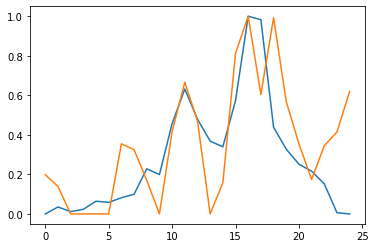

{'city': 'Peumo', 'pearson': -0.5307758752502041, 'spearman': -0.5337077793697131, 'kendalltau': -0.4042613387982436, 'MSE': 0.3262897098438738, 'MAE': 0.5022792817769106, 'dtw_L1_w5_s01': 9.836699815369435, 'dtw_L2_w5_s01': 5.819829511470689, 'dtw_L1_w5_s02': 10.110102004467167, 'dtw_L2_w5_s02': 6.100231761040606}


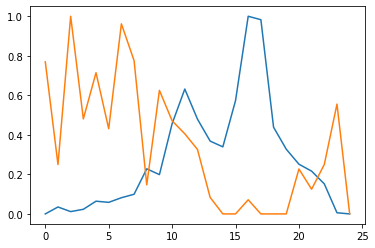

{'city': 'Pichilemu', 'pearson': 0.4607532501201287, 'spearman': 0.5096600397195536, 'kendalltau': 0.37420377950756717, 'MSE': 0.10830214029524908, 'MAE': 0.2739604472339628, 'dtw_L1_w5_s01': 5.037721844839526, 'dtw_L2_w5_s01': 1.5034379857525932, 'dtw_L1_w5_s02': 5.163018320388269, 'dtw_L2_w5_s02': 1.5897315019756613}


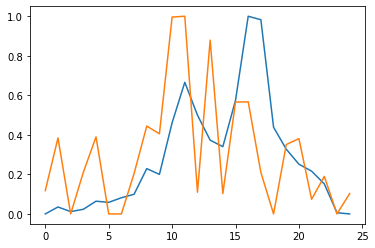

{'city': 'Pirque', 'pearson': 0.5707965532047145, 'spearman': 0.5930788782542045, 'kendalltau': 0.44061481380159484, 'MSE': 0.10497358279768211, 'MAE': 0.24804316146782837, 'dtw_L1_w5_s01': 3.846597584326501, 'dtw_L2_w5_s01': 1.144134900997262, 'dtw_L1_w5_s02': 3.99299452350727, 'dtw_L2_w5_s02': 1.1972231576621686}


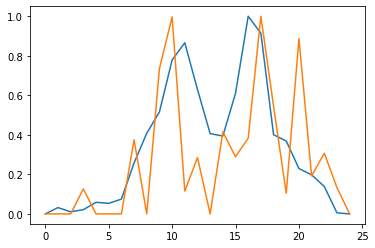

{'city': 'Quillota', 'pearson': 0.5294562059205568, 'spearman': 0.5455944594074643, 'kendalltau': 0.38795986622073575, 'MSE': 0.0735680541222765, 'MAE': 0.23117767331040337, 'dtw_L1_w5_s01': 3.281600302569012, 'dtw_L2_w5_s01': 0.6268505248699136, 'dtw_L1_w5_s02': 3.413088530737493, 'dtw_L2_w5_s02': 0.6573970131376989}


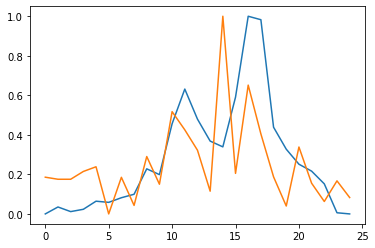

{'city': 'Quilpue', 'pearson': 0.7018924298004936, 'spearman': 0.7316791826057512, 'kendalltau': 0.5308855478188713, 'MSE': 0.1216045466030881, 'MAE': 0.29627766384875737, 'dtw_L1_w5_s01': 3.8056362895592484, 'dtw_L2_w5_s01': 1.141862882211048, 'dtw_L1_w5_s02': 4.187256305121727, 'dtw_L2_w5_s02': 1.2780240149159836}


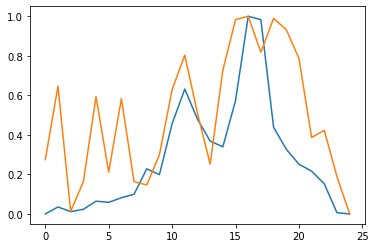

{'city': 'Rancagua', 'pearson': 0.5455286574870188, 'spearman': 0.7253846153846153, 'kendalltau': 0.5199999999999999, 'MSE': 0.0975483388840244, 'MAE': 0.2458487572517527, 'dtw_L1_w5_s01': 4.253286917224203, 'dtw_L2_w5_s01': 0.9275927198145237, 'dtw_L1_w5_s02': 4.433269160710314, 'dtw_L2_w5_s02': 0.9883258125707983}


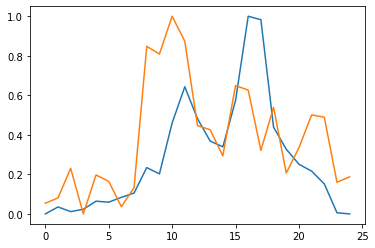

{'city': 'Rauco', 'pearson': 0.7892852620289186, 'spearman': 0.8282918606281919, 'kendalltau': 0.6307138199252044, 'MSE': 0.043814495831020185, 'MAE': 0.1502959945243639, 'dtw_L1_w5_s01': 1.7606117338161549, 'dtw_L2_w5_s01': 0.23026312850600936, 'dtw_L1_w5_s02': 1.8340933751751394, 'dtw_L2_w5_s02': 0.2429775413815005}


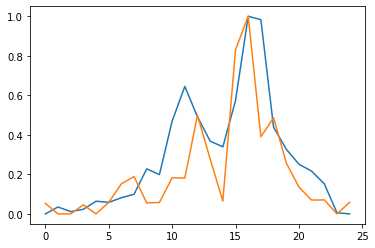

{'city': 'Rengo', 'pearson': 0.5015042163245976, 'spearman': 0.4394768888102756, 'kendalltau': 0.2635375775757995, 'MSE': 0.10494480501459574, 'MAE': 0.26169732863788947, 'dtw_L1_w5_s01': 4.208047410071775, 'dtw_L2_w5_s01': 0.9887289242009315, 'dtw_L1_w5_s02': 4.31925552953327, 'dtw_L2_w5_s02': 1.0132584295080604}


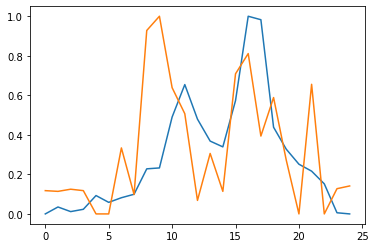

{'city': 'Romeral', 'pearson': 0.2518334359735678, 'spearman': 0.4178407880062555, 'kendalltau': 0.309943377369126, 'MSE': 0.1622958620779293, 'MAE': 0.34726359809706625, 'dtw_L1_w5_s01': 4.389290949867913, 'dtw_L2_w5_s01': 1.1577000334011471, 'dtw_L1_w5_s02': 4.556851963843904, 'dtw_L2_w5_s02': 1.2026526822292587}


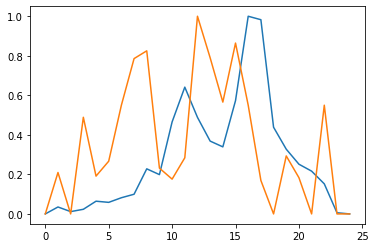

{'city': 'San Antonio', 'pearson': 0.3241941697211529, 'spearman': 0.253125605759508, 'kendalltau': 0.18363965490589887, 'MSE': 0.18038305650289957, 'MAE': 0.363020724170073, 'dtw_L1_w5_s01': 6.315406593977892, 'dtw_L2_w5_s01': 2.715059493683446, 'dtw_L1_w5_s02': 6.453782244093383, 'dtw_L2_w5_s02': 2.7743831679328195}


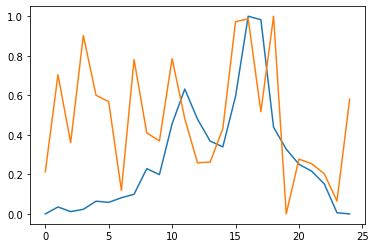

{'city': 'San Carlos', 'pearson': 0.542863168303579, 'spearman': 0.6785139308442862, 'kendalltau': 0.49241742088187723, 'MSE': 0.08396592137946109, 'MAE': 0.21448867944686864, 'dtw_L1_w5_s01': 2.4025046666857053, 'dtw_L2_w5_s01': 0.4811899894170799, 'dtw_L1_w5_s02': 2.4861993997190015, 'dtw_L2_w5_s02': 0.4991664839303668}


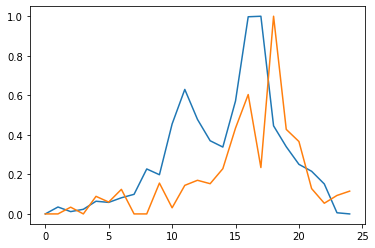

{'city': 'San Felipe', 'pearson': 0.18115169690775956, 'spearman': 0.2704366274299911, 'kendalltau': 0.19699526617178242, 'MSE': 0.17374919973309882, 'MAE': 0.34267619026408735, 'dtw_L1_w5_s01': 5.872889213681165, 'dtw_L2_w5_s01': 2.612744499328967, 'dtw_L1_w5_s02': 6.206126131399685, 'dtw_L2_w5_s02': 2.847071430212469}


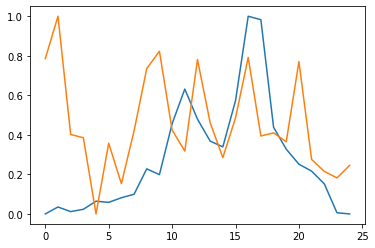

{'city': 'San Fernando', 'pearson': 0.3771963602952061, 'spearman': 0.5234797548063064, 'kendalltau': 0.35846348744245227, 'MSE': 0.11361432496749757, 'MAE': 0.28105284766283795, 'dtw_L1_w5_s01': 4.7046023517484095, 'dtw_L2_w5_s01': 1.5494669578791735, 'dtw_L1_w5_s02': 4.9466749068778855, 'dtw_L2_w5_s02': 1.6239408374148003}


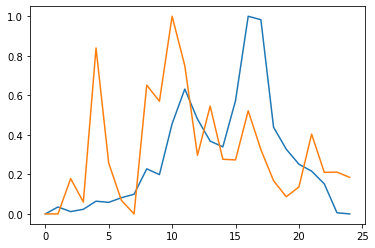

{'city': 'San Jose de Maipo', 'pearson': 0.5656958051577179, 'spearman': 0.7123368029656406, 'kendalltau': 0.525124544527047, 'MSE': 0.08011494983046223, 'MAE': 0.2101038915844804, 'dtw_L1_w5_s01': 3.340011142253047, 'dtw_L2_w5_s01': 0.7892140990390201, 'dtw_L1_w5_s02': 3.466773882344354, 'dtw_L2_w5_s02': 0.8292052390833178}


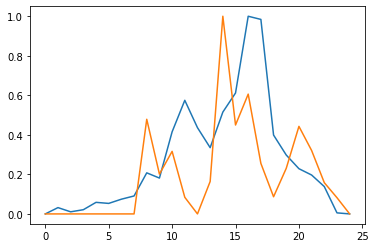

{'city': 'San Pedro', 'pearson': 0.676866341455096, 'spearman': 0.6384615384615384, 'kendalltau': 0.45333333333333325, 'MSE': 0.06964040194258898, 'MAE': 0.22676125386971274, 'dtw_L1_w5_s01': 4.296825482599206, 'dtw_L2_w5_s01': 1.0340919126886519, 'dtw_L1_w5_s02': 4.396374882229728, 'dtw_L2_w5_s02': 1.0838728036869312}


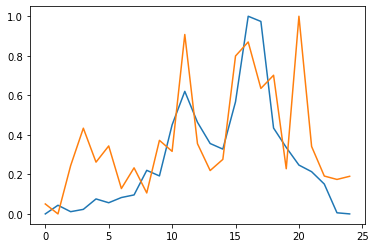

{'city': 'Santa Cruz', 'pearson': 0.4205549072243378, 'spearman': 0.5236629472874182, 'kendalltau': 0.36789297658862874, 'MSE': 0.10770687700288475, 'MAE': 0.2413391112961612, 'dtw_L1_w5_s01': 3.4745283460264638, 'dtw_L2_w5_s01': 0.9113586897371397, 'dtw_L1_w5_s02': 3.666678795015615, 'dtw_L2_w5_s02': 0.9535435761471702}


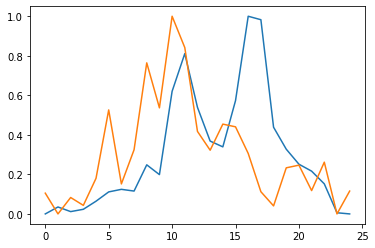

{'city': 'Santiago', 'pearson': 0.8919666885767633, 'spearman': 0.883631483935547, 'kendalltau': 0.7111862999082994, 'MSE': 0.019526100127681717, 'MAE': 0.10812857399898203, 'dtw_L1_w5_s01': 1.5961083005746717, 'dtw_L2_w5_s01': 0.14894573344724768, 'dtw_L1_w5_s02': 1.6968037414482613, 'dtw_L2_w5_s02': 0.15794690611166964}


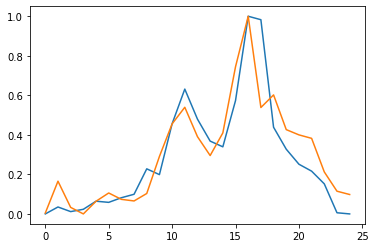

{'city': 'Talagante', 'pearson': 0.6107965455838459, 'spearman': 0.5227099316374736, 'kendalltau': 0.36516373954418035, 'MSE': 0.07607504287578253, 'MAE': 0.22874656135875243, 'dtw_L1_w5_s01': 4.619326305364713, 'dtw_L2_w5_s01': 1.1289608492952752, 'dtw_L1_w5_s02': 4.803677788533801, 'dtw_L2_w5_s02': 1.1943795480987534}


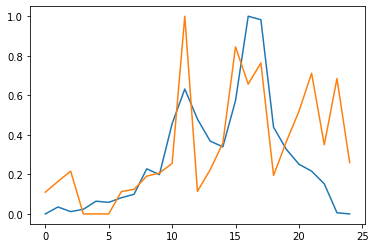

{'city': 'Talca', 'pearson': 0.8218473805847835, 'spearman': 0.9047893993105819, 'kendalltau': 0.7378975224400665, 'MSE': 0.04109104105543658, 'MAE': 0.15154714399790895, 'dtw_L1_w5_s01': 1.9290768932629865, 'dtw_L2_w5_s01': 0.2845471116898386, 'dtw_L1_w5_s02': 1.9976956636255192, 'dtw_L2_w5_s02': 0.2988819321431427}


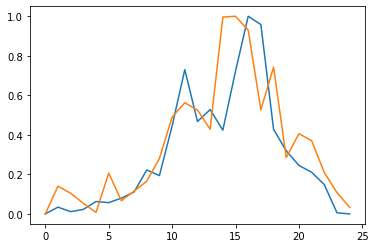

{'city': 'Talcahuano', 'pearson': 0.850372519528031, 'spearman': 0.8430769230769231, 'kendalltau': 0.6466666666666666, 'MSE': 0.028930805023924887, 'MAE': 0.1369932978798904, 'dtw_L1_w5_s01': 2.1148100240765735, 'dtw_L2_w5_s01': 0.2339598873014251, 'dtw_L1_w5_s02': 2.2429240233764913, 'dtw_L2_w5_s02': 0.2549217102440795}


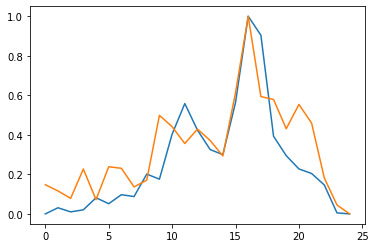

{'city': 'Tome', 'pearson': 0.3422112654422425, 'spearman': 0.5046153846153847, 'kendalltau': 0.37333333333333324, 'MSE': 0.12445867837068392, 'MAE': 0.27665098303212765, 'dtw_L1_w5_s01': 4.745165985652447, 'dtw_L2_w5_s01': 1.749583243906627, 'dtw_L1_w5_s02': 4.965109351307215, 'dtw_L2_w5_s02': 1.8255799348679704}


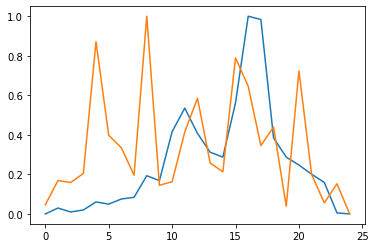

{'city': 'Tucapel', 'pearson': -0.22628929633071773, 'spearman': -0.2394622971801331, 'kendalltau': -0.16678836780303677, 'MSE': 0.20210895236194443, 'MAE': 0.3917488056880915, 'dtw_L1_w5_s01': 7.004020375520412, 'dtw_L2_w5_s01': 3.1872617845989977, 'dtw_L1_w5_s02': 7.186049743641604, 'dtw_L2_w5_s02': 3.3465639522533093}


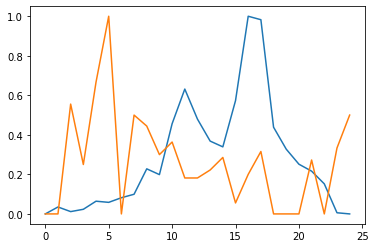

{'city': 'Valparaiso', 'pearson': 0.2123898732078225, 'spearman': 0.5074052796303816, 'kendalltau': 0.38397382389415224, 'MSE': 0.1102457182945149, 'MAE': 0.2394193341537155, 'dtw_L1_w5_s01': 4.670192271115696, 'dtw_L2_w5_s01': 2.1078047948759226, 'dtw_L1_w5_s02': 4.905520330199505, 'dtw_L2_w5_s02': 2.201146842763122}


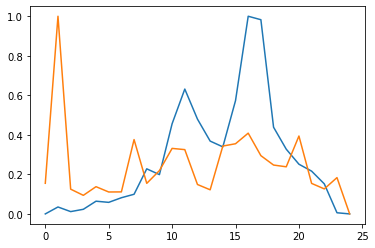

{'city': 'Villa Alemana', 'pearson': 0.24048087354578376, 'spearman': 0.3073668069936883, 'kendalltau': 0.20367307180472422, 'MSE': 0.13263999519733338, 'MAE': 0.3029601256997977, 'dtw_L1_w5_s01': 5.262538266112698, 'dtw_L2_w5_s01': 1.8939583888008016, 'dtw_L1_w5_s02': 5.537514749973489, 'dtw_L2_w5_s02': 2.043677725265254}


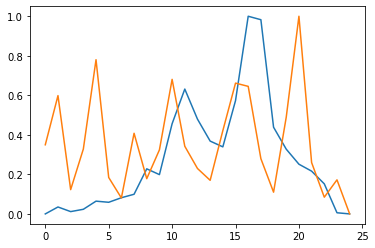

{'city': 'Viña del Mar', 'pearson': 0.7312302414985336, 'spearman': 0.7359107656807582, 'kendalltau': 0.6043414097812309, 'MSE': 0.04649127184029347, 'MAE': 0.14959973109718216, 'dtw_L1_w5_s01': 2.3048562934321346, 'dtw_L2_w5_s01': 0.5631921604291027, 'dtw_L1_w5_s02': 2.4728499367466563, 'dtw_L2_w5_s02': 0.6130099540138849}


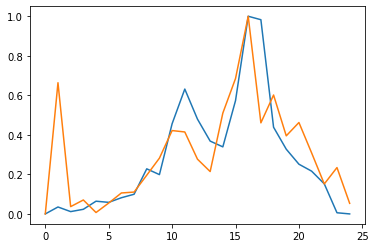

In [ ]:
m=0.04
sigma=10

for city in selected_cities_data[["lat","lon"]].itertuples():
  fai=normalize(FireAwarenessIndex((city.lat,city.lon),m,sigma,days=days[9:34]))
  twi=normalize(twitter_data["index"][city[0]][9:34])
  print({
        "city":city[0],
        "pearson":st.pearsonr(fai,twi)[0], 
        "spearman":st.spearmanr(fai,twi)[0],
        "kendalltau":st.kendalltau(fai,twi)[0], 
        "MSE":l2_norm(fai,twi).sum()/21.,
        "MAE":l1_norm(fai,twi).sum()/21.,
        "dtw_L1_w5_s01":dtw(fai,twi, l1_norm, warp=1, w=3, s=1.01)[0], 
        "dtw_L2_w5_s01":dtw(fai,twi, l2_norm, warp=1, w=3, s=1.01)[0],
        "dtw_L1_w5_s02":dtw(fai,twi, l1_norm, warp=1, w=3, s=1.02)[0], 
        "dtw_L2_w5_s02":dtw(fai,twi, l2_norm, warp=1, w=3, s=1.02)[0]
      })
  plt.plot(fai)
  plt.plot(twi)
  plt.show()
